In [565]:
# Run reviews_exploratiion.ipynb first.
import pandas as pd
import json
import ast
import numpy as np
import math
import missingno as msno

In [566]:
# Prevent printing scientific notation for latex tables.
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [567]:
# Load the reviews data.
games_reviews_long_df = pd.read_csv('games_reviews_flat.csv')
games_reviews_long_df.head()

,Unnamed: 0,igdb_id,first_release_date,name,slug,mature,single_player,multiplayer,igdb_name,opencritic_name,...,topCriticScore,percentile,firstReleaseDate,firstReviewDate,latestReviewDate,variable,igdb_company_id,developer,publisher,stock_id
0,2,117,1480982400,The Last Guardian,the-last-guardian,False,True,False,The Last Guardian,The Last Guardian,...,80.52874,83.00000,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z,pub1_stock_id,10100,False,True,JP3435000009
1,2506,119386,1606694400,Empire of Sin,empire-of-sin,True,True,False,Empire of Sin,Empire of Sin,...,62.37838,20.00000,2020-12-01T00:00:00.000Z,2020-11-30T00:00:00.000Z,2023-02-01T00:00:00.000Z,pub1_stock_id,517,False,True,SE0008294953
2,2508,119422,1568073600,eFootball PES 2020,efootball-pes-2020,False,True,False,eFootball PES 2020,eFootball PES 2020,...,81.27083,83.00000,2019-09-10T00:00:00.000Z,2019-09-09T04:00:00.000Z,2019-10-09T00:00:00.000Z,dev1_stock_id,161,True,False,JP3300200007
3,2510,119422,1568073600,eFootball PES 2020,efootball-pes-2020,False,True,False,eFootball PES 2020,eFootball PES 2020,...,81.27083,83.00000,2019-09-10T00:00:00.000Z,2019-09-09T04:00:00.000Z,2019-10-09T00:00:00.000Z,pub1_stock_id,161,False,True,JP3300200007
4,2514,120175,1582761600,One Punch Man: A Hero Nobody Knows,one-punch-man-a-hero-nobody-knows,False,True,False,One Punch Man: A Hero Nobody Knows,One-Punch Man: A Hero Nobody Knows,...,58.54902,14.00000,2020-02-28T00:00:00.000Z,2017-05-21T00:00:00.000Z,2020-07-13T00:00:00.000Z,pub1_stock_id,248,False,True,JP3778630008


In [568]:
games_reviews_long_df.columns

Index(['Unnamed: 0', 'igdb_id', 'first_release_date', 'name', 'slug', 'mature',
       'single_player', 'multiplayer', 'igdb_name', 'opencritic_name',
       'opencritic_id', 'dist', 'hasLootBoxes', 'percentRecommended',
       'numReviews', 'numTopCriticReviews', 'medianScore', 'topCriticScore',
       'percentile', 'firstReleaseDate', 'firstReviewDate', 'latestReviewDate',
       'variable', 'igdb_company_id', 'developer', 'publisher', 'stock_id'],
      dtype='object')

In [569]:
# stock_id is object and needs to be parsed as a string.
games_reviews_long_df['stock_id'] = games_reviews_long_df['stock_id'].astype('string')

In [570]:
# Parse first release date as datetime.
games_reviews_long_df['first_release_date'] = pd.to_datetime(games_reviews_long_df['first_release_date'],unit='s')

In [571]:
# Create date column from first_release_date for joining
games_reviews_long_df['date'] = games_reviews_long_df['first_release_date']

# # Parse first release date as datetime.
# games_reviews_long_df['date'] = pd.to_datetime(games_reviews_long_df['date'],unit='s', format='%Y-%m-%d')
games_reviews_long_df.dtypes

Unnamed: 0                      int64
igdb_id                         int64
first_release_date     datetime64[ns]
name                           object
slug                           object
mature                           bool
single_player                    bool
multiplayer                      bool
igdb_name                      object
opencritic_name                object
opencritic_id                   int64
dist                          float64
hasLootBoxes                   object
percentRecommended            float64
numReviews                    float64
numTopCriticReviews           float64
medianScore                   float64
topCriticScore                float64
percentile                    float64
firstReleaseDate               object
firstReviewDate                object
latestReviewDate               object
variable                       object
igdb_company_id                 int64
developer                        bool
publisher                        bool
stock_id    

In [572]:
games_reviews_long_df.head()

,Unnamed: 0,igdb_id,first_release_date,name,slug,mature,single_player,multiplayer,igdb_name,opencritic_name,...,percentile,firstReleaseDate,firstReviewDate,latestReviewDate,variable,igdb_company_id,developer,publisher,stock_id,date
0,2,117,2016-12-06,The Last Guardian,the-last-guardian,False,True,False,The Last Guardian,The Last Guardian,...,83.00000,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z,pub1_stock_id,10100,False,True,JP3435000009,2016-12-06
1,2506,119386,2020-11-30,Empire of Sin,empire-of-sin,True,True,False,Empire of Sin,Empire of Sin,...,20.00000,2020-12-01T00:00:00.000Z,2020-11-30T00:00:00.000Z,2023-02-01T00:00:00.000Z,pub1_stock_id,517,False,True,SE0008294953,2020-11-30
2,2508,119422,2019-09-10,eFootball PES 2020,efootball-pes-2020,False,True,False,eFootball PES 2020,eFootball PES 2020,...,83.00000,2019-09-10T00:00:00.000Z,2019-09-09T04:00:00.000Z,2019-10-09T00:00:00.000Z,dev1_stock_id,161,True,False,JP3300200007,2019-09-10
3,2510,119422,2019-09-10,eFootball PES 2020,efootball-pes-2020,False,True,False,eFootball PES 2020,eFootball PES 2020,...,83.00000,2019-09-10T00:00:00.000Z,2019-09-09T04:00:00.000Z,2019-10-09T00:00:00.000Z,pub1_stock_id,161,False,True,JP3300200007,2019-09-10
4,2514,120175,2020-02-27,One Punch Man: A Hero Nobody Knows,one-punch-man-a-hero-nobody-knows,False,True,False,One Punch Man: A Hero Nobody Knows,One-Punch Man: A Hero Nobody Knows,...,14.00000,2020-02-28T00:00:00.000Z,2017-05-21T00:00:00.000Z,2020-07-13T00:00:00.000Z,pub1_stock_id,248,False,True,JP3778630008,2020-02-27


In [573]:
# Load the financial data.
stock_ff_index_df = pd.read_csv('financial_data_clean.csv')
stock_ff_index_df.head()

,Unnamed: 0,gvkey,iid,date,company_name,shares_outstanding,trading_volume,closing_price,total_return_factor,stock_id,...,mkt-rf,smb,hml,rmw,cma,rf,benchmark_price,returns,benchmark_returns,excess_return
0,0,212596,01W,2015-10-01,UBI SOFT ENTERTAINMENT SA,111218465.00000,506501.00000,18.42000,1.00839,FR0000054470,...,-0.29000,0.52000,0.24000,-0.11000,0.22000,0.00000,308.80000,NaN,NaN,NaN
1,1,212596,01W,2015-10-02,UBI SOFT ENTERTAINMENT SA,111218465.00000,217260.00000,18.15500,1.00839,FR0000054470,...,0.93000,-0.36000,0.14000,-0.25000,0.22000,0.00000,310.56000,-0.01439,0.00570,-0.02009
2,2,212596,01W,2015-10-05,UBI SOFT ENTERTAINMENT SA,111218465.00000,267647.00000,18.35500,1.00839,FR0000054470,...,2.37000,-1.31000,0.43000,-0.20000,0.06000,0.00000,319.53000,0.01102,0.02888,-0.01787
3,3,212596,01W,2015-10-06,UBI SOFT ENTERTAINMENT SA,111218465.00000,984676.00000,19.90000,1.00839,FR0000054470,...,1.33000,-0.10000,0.66000,0.04000,0.05000,0.00000,321.06000,0.08417,0.00479,0.07938
4,4,212596,01W,2015-10-07,UBI SOFT ENTERTAINMENT SA,111218465.00000,740257.00000,20.12000,1.00839,FR0000054470,...,-0.07000,0.07000,1.52000,-0.54000,0.56000,0.00000,319.89000,0.01106,-0.00364,0.01470


In [574]:
stock_ff_index_df.columns

Index(['Unnamed: 0', 'gvkey', 'iid', 'date', 'company_name',
       'shares_outstanding', 'trading_volume', 'closing_price',
       'total_return_factor', 'stock_id', 'eu', 'jp', 'us', 'mkt-rf', 'smb',
       'hml', 'rmw', 'cma', 'rf', 'benchmark_price', 'returns',
       'benchmark_returns', 'excess_return'],
      dtype='object')

In [575]:
# stock_id is object and needs to be parsed as a string.
stock_ff_index_df['stock_id'] = stock_ff_index_df['stock_id'].astype('string')

In [576]:
# Convert stock_data_df date column to datetime.
stock_ff_index_df['date'] = pd.to_datetime(stock_ff_index_df['date'])
stock_ff_index_df.dtypes

Unnamed: 0                      int64
gvkey                           int64
iid                            object
date                   datetime64[ns]
company_name                   object
shares_outstanding            float64
trading_volume                float64
closing_price                 float64
total_return_factor           float64
stock_id               string[python]
eu                               bool
jp                               bool
us                               bool
mkt-rf                        float64
smb                           float64
hml                           float64
rmw                           float64
cma                           float64
rf                            float64
benchmark_price               float64
returns                       float64
benchmark_returns             float64
excess_return                 float64
dtype: object

In [577]:
stock_ff_index_df.head()

,Unnamed: 0,gvkey,iid,date,company_name,shares_outstanding,trading_volume,closing_price,total_return_factor,stock_id,...,mkt-rf,smb,hml,rmw,cma,rf,benchmark_price,returns,benchmark_returns,excess_return
0,0,212596,01W,2015-10-01,UBI SOFT ENTERTAINMENT SA,111218465.00000,506501.00000,18.42000,1.00839,FR0000054470,...,-0.29000,0.52000,0.24000,-0.11000,0.22000,0.00000,308.80000,NaN,NaN,NaN
1,1,212596,01W,2015-10-02,UBI SOFT ENTERTAINMENT SA,111218465.00000,217260.00000,18.15500,1.00839,FR0000054470,...,0.93000,-0.36000,0.14000,-0.25000,0.22000,0.00000,310.56000,-0.01439,0.00570,-0.02009
2,2,212596,01W,2015-10-05,UBI SOFT ENTERTAINMENT SA,111218465.00000,267647.00000,18.35500,1.00839,FR0000054470,...,2.37000,-1.31000,0.43000,-0.20000,0.06000,0.00000,319.53000,0.01102,0.02888,-0.01787
3,3,212596,01W,2015-10-06,UBI SOFT ENTERTAINMENT SA,111218465.00000,984676.00000,19.90000,1.00839,FR0000054470,...,1.33000,-0.10000,0.66000,0.04000,0.05000,0.00000,321.06000,0.08417,0.00479,0.07938
4,4,212596,01W,2015-10-07,UBI SOFT ENTERTAINMENT SA,111218465.00000,740257.00000,20.12000,1.00839,FR0000054470,...,-0.07000,0.07000,1.52000,-0.54000,0.56000,0.00000,319.89000,0.01106,-0.00364,0.01470


Begin by joining the reviews dataset with the financial dataset on release date and stock_id.

In [578]:
# Convert both dfs date columns to the same type.
# stock_ff_index_df['date'] = pd.to_datetime(stock_ff_index_df['date'])
# games_reviews_long_df['date'] = pd.to_datetime(games_reviews_long_df['date'])
stock_ff_index_df.date = stock_ff_index_df['date'].astype('string')
games_reviews_long_df.date = games_reviews_long_df['date'].astype('string')


In [579]:
games_reviews_long_df.dtypes

Unnamed: 0                      int64
igdb_id                         int64
first_release_date     datetime64[ns]
name                           object
slug                           object
mature                           bool
single_player                    bool
multiplayer                      bool
igdb_name                      object
opencritic_name                object
opencritic_id                   int64
dist                          float64
hasLootBoxes                   object
percentRecommended            float64
numReviews                    float64
numTopCriticReviews           float64
medianScore                   float64
topCriticScore                float64
percentile                    float64
firstReleaseDate               object
firstReviewDate                object
latestReviewDate               object
variable                       object
igdb_company_id                 int64
developer                        bool
publisher                        bool
stock_id    

In [580]:
games_reviews_long_df.head()

,Unnamed: 0,igdb_id,first_release_date,name,slug,mature,single_player,multiplayer,igdb_name,opencritic_name,...,percentile,firstReleaseDate,firstReviewDate,latestReviewDate,variable,igdb_company_id,developer,publisher,stock_id,date
0,2,117,2016-12-06,The Last Guardian,the-last-guardian,False,True,False,The Last Guardian,The Last Guardian,...,83.00000,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z,pub1_stock_id,10100,False,True,JP3435000009,2016-12-06
1,2506,119386,2020-11-30,Empire of Sin,empire-of-sin,True,True,False,Empire of Sin,Empire of Sin,...,20.00000,2020-12-01T00:00:00.000Z,2020-11-30T00:00:00.000Z,2023-02-01T00:00:00.000Z,pub1_stock_id,517,False,True,SE0008294953,2020-11-30
2,2508,119422,2019-09-10,eFootball PES 2020,efootball-pes-2020,False,True,False,eFootball PES 2020,eFootball PES 2020,...,83.00000,2019-09-10T00:00:00.000Z,2019-09-09T04:00:00.000Z,2019-10-09T00:00:00.000Z,dev1_stock_id,161,True,False,JP3300200007,2019-09-10
3,2510,119422,2019-09-10,eFootball PES 2020,efootball-pes-2020,False,True,False,eFootball PES 2020,eFootball PES 2020,...,83.00000,2019-09-10T00:00:00.000Z,2019-09-09T04:00:00.000Z,2019-10-09T00:00:00.000Z,pub1_stock_id,161,False,True,JP3300200007,2019-09-10
4,2514,120175,2020-02-27,One Punch Man: A Hero Nobody Knows,one-punch-man-a-hero-nobody-knows,False,True,False,One Punch Man: A Hero Nobody Knows,One-Punch Man: A Hero Nobody Knows,...,14.00000,2020-02-28T00:00:00.000Z,2017-05-21T00:00:00.000Z,2020-07-13T00:00:00.000Z,pub1_stock_id,248,False,True,JP3778630008,2020-02-27


In [581]:
games_reviews_returns_df = pd.merge(games_reviews_long_df, stock_ff_index_df, how='left', on=['date', 'stock_id'])
games_reviews_returns_df.head()

,Unnamed: 0_x,igdb_id,first_release_date,name,slug,mature,single_player,multiplayer,igdb_name,opencritic_name,...,mkt-rf,smb,hml,rmw,cma,rf,benchmark_price,returns,benchmark_returns,excess_return
0,2,117,2016-12-06,The Last Guardian,the-last-guardian,False,True,False,The Last Guardian,The Last Guardian,...,0.49000,-0.09000,1.07000,-0.27000,0.14000,0.00000,1394.21000,-0.00773,0.00176,-0.00949
1,2,117,2016-12-06,The Last Guardian,the-last-guardian,False,True,False,The Last Guardian,The Last Guardian,...,0.49000,-0.09000,1.07000,-0.27000,0.14000,0.00000,1394.21000,-0.00772,0.00176,-0.00949
2,2,117,2016-12-06,The Last Guardian,the-last-guardian,False,True,False,The Last Guardian,The Last Guardian,...,0.49000,-0.09000,1.07000,-0.27000,0.14000,0.00000,1394.21000,0.01166,-0.00398,0.01564
3,2506,119386,2020-11-30,Empire of Sin,empire-of-sin,True,True,False,Empire of Sin,Empire of Sin,...,-1.10000,0.47000,-1.31000,0.02000,-0.63000,0.00000,575.44000,0.03451,-0.00260,0.03711
4,2506,119386,2020-11-30,Empire of Sin,empire-of-sin,True,True,False,Empire of Sin,Empire of Sin,...,-1.10000,0.47000,-1.31000,0.02000,-0.63000,0.00000,575.44000,0.08465,-0.00260,0.08725


In [582]:
games_reviews_returns_df = games_reviews_returns_df.dropna()

<Axes: >

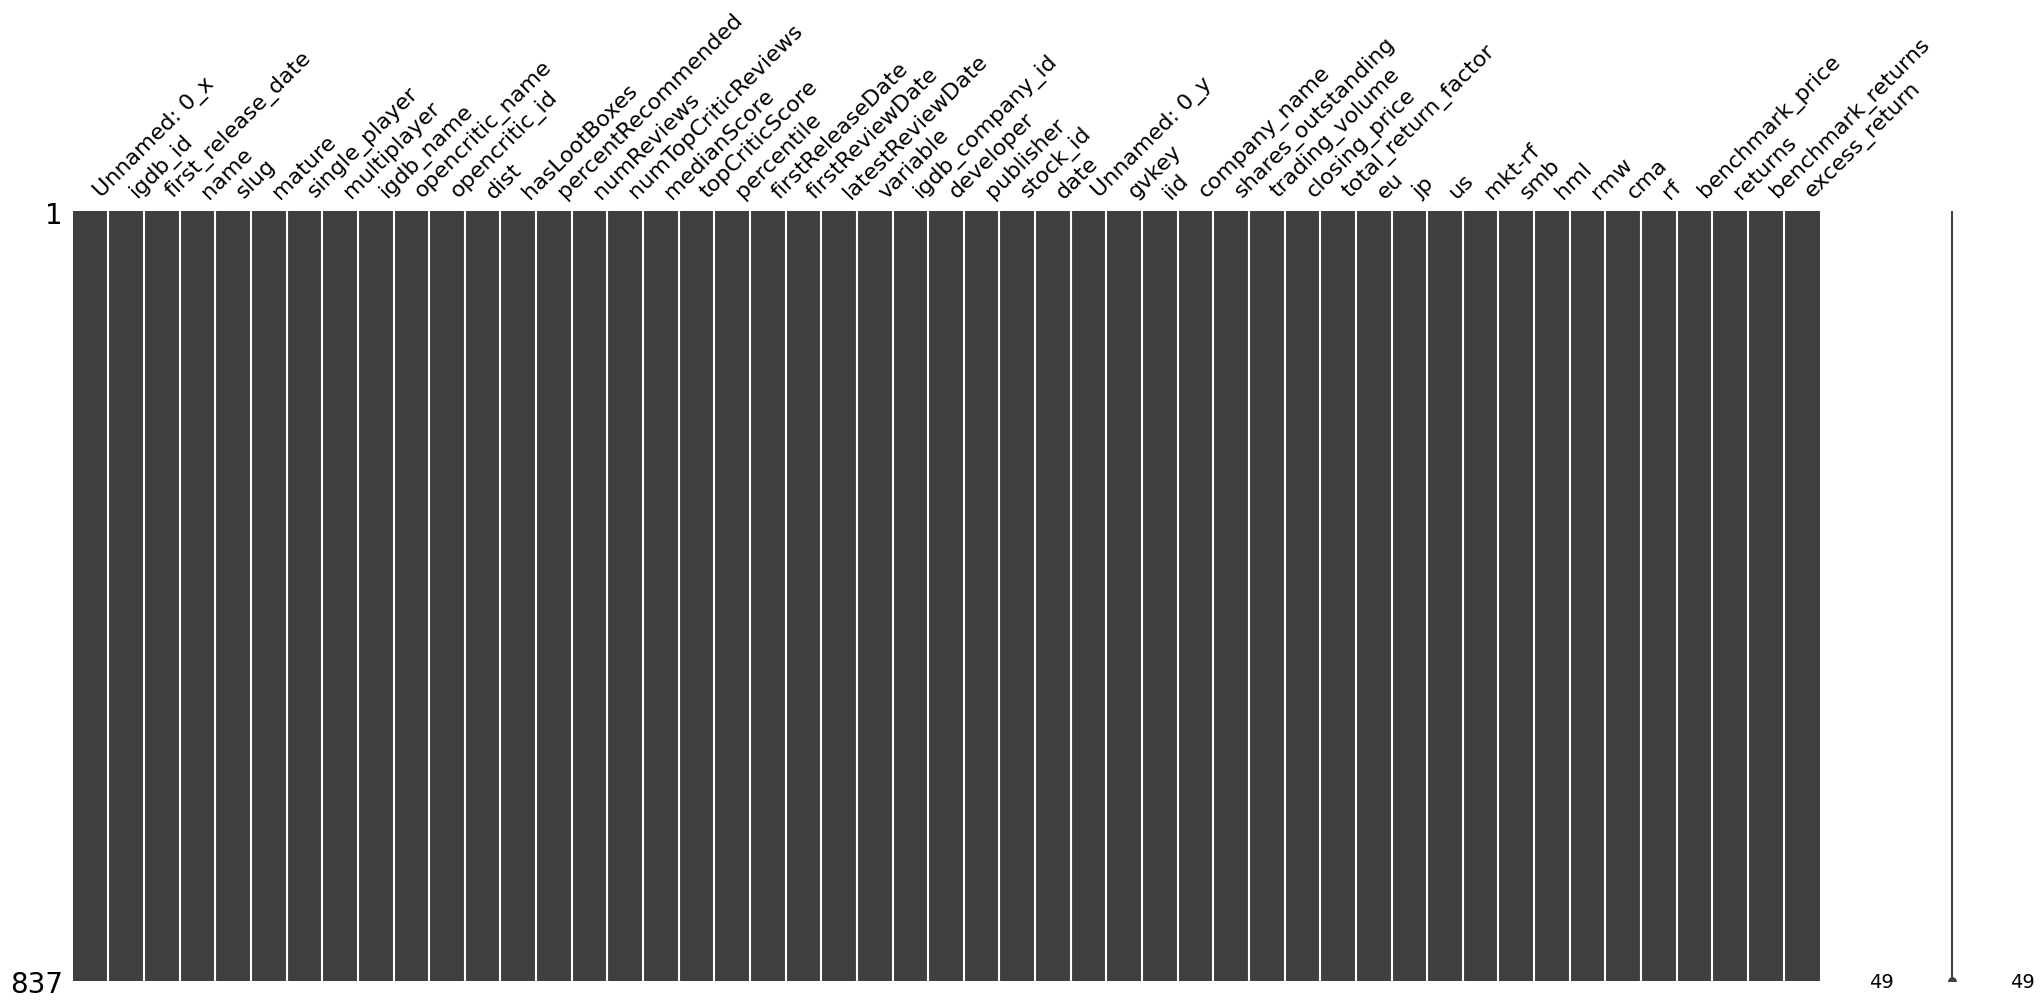

In [583]:
# Plot missing data.
%matplotlib inline

msno.matrix(games_reviews_returns_df)

In [584]:
# Add in a market capitalization column.
games_reviews_returns_df['market_cap'] = games_reviews_returns_df['shares_outstanding'] * games_reviews_returns_df['closing_price']


In [585]:
games_reviews_returns_df.columns

Index(['Unnamed: 0_x', 'igdb_id', 'first_release_date', 'name', 'slug',
       'mature', 'single_player', 'multiplayer', 'igdb_name',
       'opencritic_name', 'opencritic_id', 'dist', 'hasLootBoxes',
       'percentRecommended', 'numReviews', 'numTopCriticReviews',
       'medianScore', 'topCriticScore', 'percentile', 'firstReleaseDate',
       'firstReviewDate', 'latestReviewDate', 'variable', 'igdb_company_id',
       'developer', 'publisher', 'stock_id', 'date', 'Unnamed: 0_y', 'gvkey',
       'iid', 'company_name', 'shares_outstanding', 'trading_volume',
       'closing_price', 'total_return_factor', 'eu', 'jp', 'us', 'mkt-rf',
       'smb', 'hml', 'rmw', 'cma', 'rf', 'benchmark_price', 'returns',
       'benchmark_returns', 'excess_return', 'market_cap'],
      dtype='object')

In [586]:
games_reviews_returns_df.describe()[[
    'dist',
    'percentRecommended',
    'numReviews',
    'numTopCriticReviews',
    'medianScore',
    'topCriticScore',
    ]].style.format({'D':'{:0.5f}'},precision=5).to_latex('games_descriptive_stats.tex')

In [587]:
games_reviews_returns_df.describe()[[
    'market_cap',
    'trading_volume',
    'mkt-rf',
    'smb',
    'hml',
    'rmw',
    'cma',
    'rf',
    'returns',
    'benchmark_returns',
    'excess_return'
    ]].style.format({'D':'{:0.5f}'},precision=5).to_latex('companies_descriptive_stats.tex')

In [588]:
games_reviews_returns_df.to_csv('games_returns_release_date.csv')

In [589]:
# Count the number of games.
games_reviews_returns_df.shape[0]

837

In [590]:
# Count the number of eu companies.
games_reviews_returns_df[games_reviews_returns_df['eu'] == True].shape[0]

262

In [591]:
# Count the number of jp companies.
games_reviews_returns_df[games_reviews_returns_df['jp'] == True].shape[0]

516

In [592]:
# Count the number of us companies.
games_reviews_returns_df[games_reviews_returns_df['us'] == True].shape[0]

59

In [593]:
# Count the number of games from developers.
games_reviews_returns_df[games_reviews_returns_df['developer'] == True].shape[0]

129

In [594]:
# Count the number of games from publisher.
games_reviews_returns_df[games_reviews_returns_df['publisher'] == True].shape[0]

708